In [1]:
import tensorflow as tf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tensorflow import keras
# Set data type
DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)



class PINNSolver:
    def __init__(self, model=None, is_pinn=True, *args, **kwargs):
        self.model = model

        # Initialize history of losses and global iteration counter
        self.current_loss = 0
        self.hist = []
        self.iter = 0
        self.hello_pinn_info = 'Hello PINN!'
        self.is_pinn = is_pinn
        self.loss1 = None
        self.loss2 = None

    def get_residual_loss(self):
        tf.print('get_residual_loss')
        return self.residual_function()

    def objective_function(self, x, y):

        # Add neural network loss
        y_pred = self.model(x)

        # Initialize loss
        self.loss1 = tf.reduce_mean(tf.square(y - y_pred))

        if self.is_pinn:
            # Compute residuals
            residual_loss = self.get_residual_loss()
            res_loss_mse = tf.reduce_mean(tf.square(residual_loss))
            self.loss2 = res_loss_mse
            #tf.print((self.loss2/self.loss1)*100)
            
            # loss = self.loss2

            loss = self.loss1 + self.loss2

        else:
            loss = self.loss1
            
        
        #tf.print('loss sum')
        return loss

    def get_grad(self, x, y):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.model.trainable_variables)
            loss = self.objective_function(x, y)

        loss_grad = tape.gradient(loss, self.model.trainable_variables)
        del tape
        #tf.print('getgrad')

        return loss, loss_grad

    def residual_function(self, *args):
        """Residual of the PDE"""
        self.hello_pinn_info = "Goodbye PINN!"
        return 0

    def solve_with_tf_optimizer(self, optimizer=tf.keras.optimizers.Adam(), x=None, y=None, n_step=1001):
        """This method performs a gradient descent type optimization."""

        @tf.function
        def train_step():
            loss, loss_grad = self.get_grad(x, y)

            # Perform gradient descent step
            optimizer.apply_gradients(zip(loss_grad, self.model.trainable_variables))
            tf.print('trainstep, with adam')
            return loss

        for i in range(n_step):
            loss = train_step()

            self.current_loss = loss.numpy()
            self.callback()

   # def solve_with_scipy_optimizer(self, x, u, method='L-BFGS-B', **kwargs):
    #    """This method provides an interface to solve the learning problem
     #   using a routine from scipy.optimize.minimize.
      #  (Tensorflow 1.xx had an interface implemented, which is not longer
       # supported in Tensorflow 2.xx.)
        #Type conversion is necessary since scipy-routines are written in Fortran
        #which requires 64-bit floats instead of 32-bit floats."""

      #  def get_weight_tensor():
       #     """Function to return current variables of the model
        #    as 1d tensor as well as corresponding shapes as lists."""
         #   weight_list = []
          #  shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors and unknown parameters
           # for v in self.model.variables:
            #    shape_list.append(v.shape)
             #   weight_list.extend(v.numpy().flatten())
#
 #           weight_list = tf.convert_to_tensor(weight_list)
  #          return weight_list, shape_list

   #     x0, shape_list = get_weight_tensor()

    #    def set_weight_tensor(weight_list):
     #       """Function which sets list of weights
      #      to variables in the model."""
       #     idx = 0
        #    for v in self.model.variables:
         #       vs = v.shape
#
 #               # Weight matrices
  #              if len(vs) == 2:
   #                 sw = vs[0] * vs[1]
    #                new_val = tf.reshape(weight_list[idx:idx + sw], (vs[0], vs[1]))
     #               idx += sw
#
 #               # Bias vectors
  #              elif len(vs) == 1:
   #                 new_val = weight_list[idx:idx + vs[0]]
    #                idx += vs[0]
#
 #               # Variables (in case of parameter identification setting)
  #              elif len(vs) == 0:
   #                 new_val = weight_list[idx]
    #                idx += 1
#
 #               ''' Error should raise if vs > 2: not implemented yet! '''
#
 #               # Assign variables (Casting necessary since scipy requires float64 type)
  #              v.assign(tf.cast(new_val, DTYPE))
#
 #       def get_loss_and_grad(weights):
  #          """Function that provides current loss and gradient
   ##
     #       # Update weights in model
      #      set_weight_tensor(weights)
       #     # Determine value of \phi and gradient w.r.t. \theta at w
        #    loss, loss_grad = self.get_grad(x, u)

            # Store current loss for callback function
         #   loss = loss.numpy().astype(np.float64)
          #  self.current_loss = loss

            # Flatten gradient
           # grad_flat = []
            #for g in loss_grad:
             #   grad_flat.extend(g.numpy().flatten())

            # Gradient list to array
        #    grad_flat = np.array(grad_flat, dtype=np.float64)

            # Return value and gradient of \phi as tuple
         #   return loss, grad_flat

       # return minimize(fun=get_loss_and_grad,
        #                x0=x0,
         #               jac=True,
          #              method=method,
           #             callback=self.callback,
            #            options={'maxiter': 10000000,
             #                    'maxfun': 5000000,
              #                   'maxcor': 5,
               #                  'maxls': 5,
                #                 'ftol': 1.0 * np.finfo(float).eps},
                 #       **kwargs)

   # def callback(self, xr=None):
    #    if self.iter % 10 == 0:
     #       print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss))
      #  self.hist.append(self.current_loss)
       # self.iter += 1

C:\Users\ryans\AppData\Local\Temp/ipykernel_22380/2784608639.py:134: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set


240
trainstep, with adam
It 00000: loss = 2.03590851e+01
trainstep, with adam
It 00001: loss = 1.93352928e+01
trainstep, with adam
It 00002: loss = 1.83197975e+01
trainstep, with adam
It 00003: loss = 1.72649384e+01
trainstep, with adam
It 00004: loss = 1.61208630e+01
trainstep, with adam
It 00005: loss = 1.48469267e+01
trainstep, with adam
It 00006: loss = 1.34338932e+01
trainstep, with adam
It 00007: loss = 1.19085674e+01
trainstep, with adam
It 00008: loss = 1.03504944e+01
trainstep, with adam
It 00009: loss = 8.93700027e+00
trainstep, with adam
It 00010: loss = 7.99646091e+00
trainstep, with adam
It 00011: loss = 7.96222401e+00
trainstep, with adam
It 00012: loss = 8.73643112e+00
trainstep, with adam
It 00013: loss = 9.30611134e+00
trainstep, with adam
It 00014: loss = 9.21050358e+00
trainstep, with adam
It 00015: loss = 8.59557056e+00
trainstep, with adam
It 00016: loss = 7.86988592e+00
trainstep, with adam
It 00017: loss = 7.32742214e+00
trainstep, with adam
It 00018: loss = 7.06

It 00154: loss = 1.26241045e-02
trainstep, with adam
It 00155: loss = 1.24711348e-02
trainstep, with adam
It 00156: loss = 1.23337852e-02
trainstep, with adam
It 00157: loss = 1.22096175e-02
trainstep, with adam
It 00158: loss = 1.20954961e-02
trainstep, with adam
It 00159: loss = 1.19878147e-02
trainstep, with adam
It 00160: loss = 1.18837543e-02
trainstep, with adam
It 00161: loss = 1.17839258e-02
trainstep, with adam
It 00162: loss = 1.16866557e-02
trainstep, with adam
It 00163: loss = 1.15904324e-02
trainstep, with adam
It 00164: loss = 1.14954812e-02
trainstep, with adam
It 00165: loss = 1.14017883e-02
trainstep, with adam
It 00166: loss = 1.13091571e-02
trainstep, with adam
It 00167: loss = 1.12168370e-02
trainstep, with adam
It 00168: loss = 1.11259148e-02
trainstep, with adam
It 00169: loss = 1.10371616e-02
trainstep, with adam
It 00170: loss = 1.09507060e-02
trainstep, with adam
It 00171: loss = 1.08674187e-02
trainstep, with adam
It 00172: loss = 1.07880151e-02
trainstep, wit

It 00308: loss = 7.66665302e-03
trainstep, with adam
It 00309: loss = 7.65910977e-03
trainstep, with adam
It 00310: loss = 7.65165780e-03
trainstep, with adam
It 00311: loss = 7.64428033e-03
trainstep, with adam
It 00312: loss = 7.63698108e-03
trainstep, with adam
It 00313: loss = 7.62978056e-03
trainstep, with adam
It 00314: loss = 7.62264105e-03
trainstep, with adam
It 00315: loss = 7.61558861e-03
trainstep, with adam
It 00316: loss = 7.60859950e-03
trainstep, with adam
It 00317: loss = 7.60170445e-03
trainstep, with adam
It 00318: loss = 7.59487320e-03
trainstep, with adam
It 00319: loss = 7.58811831e-03
trainstep, with adam
It 00320: loss = 7.58142723e-03
trainstep, with adam
It 00321: loss = 7.57482462e-03
trainstep, with adam
It 00322: loss = 7.56828394e-03
trainstep, with adam
It 00323: loss = 7.56182848e-03
trainstep, with adam
It 00324: loss = 7.55542377e-03
trainstep, with adam
It 00325: loss = 7.54909497e-03
trainstep, with adam
It 00326: loss = 7.54283881e-03
trainstep, wit

trainstep, with adam
It 00463: loss = 7.09338952e-03
trainstep, with adam
It 00464: loss = 7.09190266e-03
trainstep, with adam
It 00465: loss = 7.09045259e-03
trainstep, with adam
It 00466: loss = 7.08900392e-03
trainstep, with adam
It 00467: loss = 7.08757341e-03
trainstep, with adam
It 00468: loss = 7.08615966e-03
trainstep, with adam
It 00469: loss = 7.08475476e-03
trainstep, with adam
It 00470: loss = 7.08337268e-03
trainstep, with adam
It 00471: loss = 7.08200177e-03
trainstep, with adam
It 00472: loss = 7.08064390e-03
trainstep, with adam
It 00473: loss = 7.07929581e-03
trainstep, with adam
It 00474: loss = 7.07796356e-03
trainstep, with adam
It 00475: loss = 7.07664620e-03
trainstep, with adam
It 00476: loss = 7.07533211e-03
trainstep, with adam
It 00477: loss = 7.07404129e-03
trainstep, with adam
It 00478: loss = 7.07275979e-03
trainstep, with adam
It 00479: loss = 7.07149133e-03
trainstep, with adam
It 00480: loss = 7.07023311e-03
trainstep, with adam
It 00481: loss = 7.068990

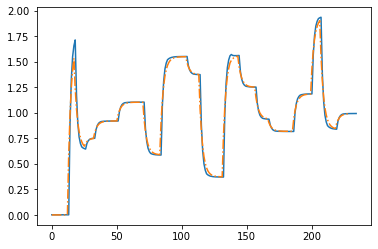

In [83]:
#from PINN.pinn_solver import PINNSolver
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
import time
import pandas as pd


# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback


DTYPE = 'float32'
tf.random.set_seed(12345)
np.random.seed(12345)


class SPINN(PINNSolver):
    def __init__(self, x_r, u_r, s1, s2, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Store Model Variables
        self.K = 1.0
        self.tau = 2.0
        # Store Model Constants

        # Store collocation points
        self.x_r = x_r
        self.u = u_r
        self.s1 = s1
        self.s2 = s2
        self.dt = 1
        
    @tf.function
    def get_residual_loss(self):
    #     with tf.GradientTape(persistent=True) as tape:
    #         # Watch variables representing t and x during this GradientTape
    #         # tape.watch(self.t)

    #         # Compute current values y(t,x)
        y = self.model(self.x_r)
            
    #         # y_t = tape.gradient(y, self.t)
    #     # y_tt = tape.gradient(y_t, self.t)

    #     del tape
        #tf.print('residual loss')

        return self.residual_function(self.u, y)

    def residual_function(self, u, y_nn):
        """Residual of the ODE"""
        # y = self.s2.inverse_transform(y_nn)
        y = (y_nn+1)/2 * (self.s2.data_max_[0]-self.s2.data_min_[0])+self.s2.data_min_[0]

        # res = y_tt + self.mu*y_t + self.k*y
        # y = self.model(self.Xs[:])
        y_t = (y[1:]-y[:-1]) / self.dt
        y = y[0:-1]
        u = u[0:-1]
        res = self.tau * y_t + y - self.K * u
        # res[0] -= qh
        # return y_t/3000.0*100.0 - self.model.alpha * y_xx/(0.1-0.001)**2*100 + self.model.beta * (y*100+20 - self.Ts)
        #tf.print('res')
        return 1e1*res

    def callback(self, *args):
        if self.iter % 1 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter, self.current_loss)
                  )
        self.hist.append(self.current_loss)
        self.iter += 1


# Load Data
data = pd.read_pickle('open_loop_data_SISO.pkl')


window = 5

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(data[['u','y']].to_numpy())
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(data[['y']].to_numpy())

# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window

dump(model_params, open('model_param.pkl', 'wb'))



# def oscillator(d, w0, x):
#     """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
#     Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
#     assert d < w0
#     w = np.sqrt(w0 ** 2 - d ** 2)
#     phi = np.arctan(-d / w)
#     A = 1 / (2 * np.cos(phi))
#     cos = tf.cos(phi + w * x)
#     sin = tf.sin(phi + w * x)
#     exp = tf.exp(-d * x)
#     y = exp * 2 * A * cos
#     return y


# d, w0 = 2, 20
# x = tf.linspace(0, 1, 500)
# y = oscillator(d, w0, x)
# print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
# x_data = x[0:200:20][:, None]
# y_data = y[0:200:20][:, None]
# print(x_data.shape, y_data.shape)

nstep = Xs.shape[0]
val_ratio = 0.15
cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set
print(cut_index)
Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

X_train = []
Y_train = []
for i in range(window,len(Xs_train)):
    X_train.append(Xs_train[i-window:i,:])
    Y_train.append(Ys_train[i])

X_val = []
Y_val = []
for i in range(window,len(Xs_val)):
    X_val.append(Xs_val[i-window:i,:])
    Y_val.append(Ys_val[i])

# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)


# # Initialize LSTM model
model_lstm = Sequential()

model_lstm.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=Y_train.shape[1])) #units = number of outputs
# model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
            #   metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

# Fit (and time) LSTM model
# t0 = time.time()
# result_lstm = model_lstm.fit(X_train, Y_train, epochs = 300, batch_size = 250,\
#                              callbacks=[es_lstm, TqdmCallback(verbose=1)],\
#                              verbose=0, validation_data=(X_val, Y_val))
# t1 = time.time()
# print('Runtime: %.2f s' %(t1-t0))


# layers = [1, 32, 32, 32, 1]

# # Input Layer
# model.add(tf.keras.layers.InputLayer(input_shape=(layers[0])))

# # Hidden Layers
# for n_i in range(1, len(layers) - 1):
#     model.add(tf.keras.layers.Dense(units=layers[n_i],
#                                     activation='tanh',
#                                     kernel_initializer='glorot_normal')
#               )

# model.add(tf.keras.layers.Dense(units=layers[-1], kernel_initializer='glorot_normal')
#           )


# x_physics = x[::5][:, None]
# y_physics = y[::5][:, None]
# x_physics = tf.convert_to_tensor(x_physics.numpy(), dtype=DTYPE)
# y_physics = tf.convert_to_tensor(y_physics.numpy(), dtype=DTYPE)

# x_physics = data["u"]
# y_physics = data["y"]
# x_physics = tf.convert_to_tensor(x_physics.numpy(), dtype=DTYPE)
# y_physics = tf.convert_to_tensor(y_physics.numpy(), dtype=DTYPE)

u_r = data["u"].to_numpy()[window:Xs_train.shape[0],None]
u_r = tf.convert_to_tensor(u_r, DTYPE)


solver = SPINN(model=model_lstm, x_r=X_train,u_r=u_r, s1=s1, s2=s2, is_pinn=True)

# # Choose step sizes aka learning rate
# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 5000], [1e-3, 1e-4, 1e-5])

# Solve with Adam optimizer
optim = tf.keras.optimizers.Adam()

X_train = tf.convert_to_tensor(X_train, DTYPE)
Y_train = tf.convert_to_tensor(Y_train, DTYPE)

# solver.solve_with_tf_optimizer(optim, X_train, Y_train, n_step=300)
solver.is_pinn = True
solver.solve_with_tf_optimizer(optim, X_train, Y_train, n_step=500)
#solver.solve_with_tf_optimizer(optim, X_val, Y_val, n_step=100)



#solver.solve_with_scipy_optimizer(X_train, Y_train, method='L-BFGS-B')
# solver.solve_with_scipy_optimizer(x_physics, y_physics, method='SLSQP')

yp = solver.model(X_train)
y_pinn = s2.inverse_transform(yp)

plt.plot(y_pinn)
plt.plot(data["y"].to_numpy()[window:len(X_train)], '-.')
plt.show()

In [71]:
print(len(X_train))




395


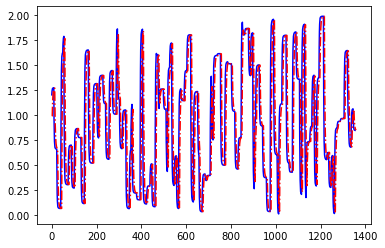

In [84]:

yp = solver.model(X_val)
y_pinn = s2.inverse_transform(yp)
#The Zero start of this graph is at the end of of the training
plt.plot(y_pinn, color='blue')
plt.plot(data["y"].to_numpy()[len(X_train)+window:], '-.',color='red')
plt.show()

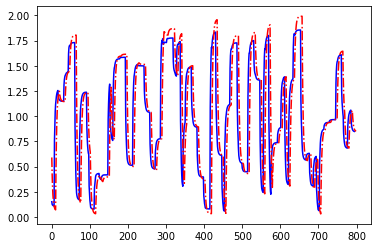

In [80]:
yp = solver.model(X_val)
y_pinn = s2.inverse_transform(yp)
plt_start=400
plt_end=1600


plt.plot(y_pinn[plt_start:plt_end], color='blue')
plt.plot(data["y"].to_numpy()[len(X_train)+window+plt_start:plt_end], '-.',color='red')
plt.show()

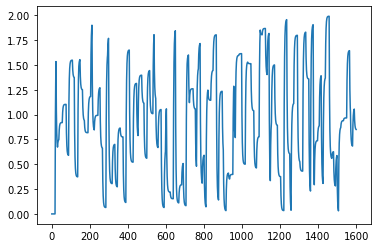

In [5]:
plt.plot(data['y'])